In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from control import *
%matplotlib inline

In [2]:
sns.set_color_codes(palette='dark')
sns.set(style="whitegrid")

In [3]:
np.random.seed(0)

In [4]:
# define the input parameters
fsample = 100
Ts=1/fsample                      # sample frequency and sample period
Ndata1 = 1000                     # length of the signal
t = np.arange(0,Ndata1)*Ts               # time axis
Nsines = 1000                       # number of sines
f = np.arange(0,Ndata1)*fsample/Ndata1   # multisine frequencies
LinesPlot = np.arange(1,np.floor(Ndata1/2)+1)   # lines to be plotted

In [5]:
# multisine 2: with a random phase
U2 = np.zeros((Ndata1,1), dtype=complex)             # choose random phases
U2[0:Nsines] = np.exp(1j*2*np.pi*np.random.rand(Nsines,1))
u2 = 2*((np.fft.ifft(U2)).real)
u2=u2/(u2.std(axis=0))
U2m = np.fft.fft(u2)/np.sqrt(Ndata1);       # spectrum of the actual generate multisine

utra = u2;

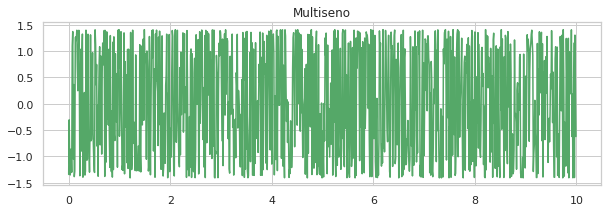

In [6]:
fig,axes = plt.subplots(figsize=(10,3))

axes.set_title("Multiseno")
axes.plot(t,u2,color='g')

fig.savefig("multiseno.png",dpi=200, bbox_inches='tight')

In [7]:
m = 0.1
b = 1
k = 10
Ts = 0.01

In [8]:
G = tf(1,[m,b,k])
print(G)


        1
----------------
0.1 s^2 + s + 10



In [9]:
c2d(G,Ts) # Ts is sample time


0.0004833 z + 0.0004675
-----------------------
z^2 - 1.895 z + 0.9048

dt = 0.01

In [10]:
th = np.array([[-1.895, 0.9048, 0.0004833, 0.0004675]]).transpose()
print(th)

[[-1.895e+00]
 [ 9.048e-01]
 [ 4.833e-04]
 [ 4.675e-04]]


In [11]:
N = 1000
t = np.arange(0,N)
sig = 0.005

In [12]:
u = utra
y = np.array(np.zeros((N,1)))

In [13]:
for k in range(2, N):
    y[k] = -th[0]*y[k-1] - th[1]*y[k-2] + th[2]*u[k-1] + th[3]*u[k-2]

In [14]:
UTRA = u
YTRA = y + sig*np.random.rand(N,1)

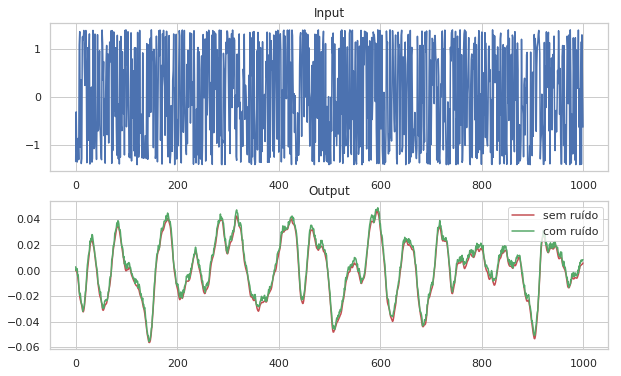

In [15]:
fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))

axes[0].set_title("Input")
axes[0].plot(t,UTRA,color='b')

axes[1].set_title("Output")
axes[1].plot(t,y,color='r',label='sem ruído')
axes[1].plot(t,YTRA,color='g',label='com ruído')
axes[1].legend(loc=1)

fig.savefig("funcoes.png",dpi=200, bbox_inches='tight')

In [16]:
uamp = 10
yr = 1
u = np.array(uamp*np.ones((N,1)))
y = np.array(np.zeros((N,1)))

In [17]:
for k in range(2,N):
    if (y[k-1] >= yr):
        u[k] = -uamp
    elif (y[k-1] <= -yr):
        u[k] = uamp;
    else:
        u[k] = u[k-1]
    y[k] = -th[0]*y[k-1] - th[1]*y[k-2] + th[2]*u[k-1] + th[3]*u[k-2]

In [18]:
UVAL = u
YVAL = y + sig*np.random.rand(N,1)

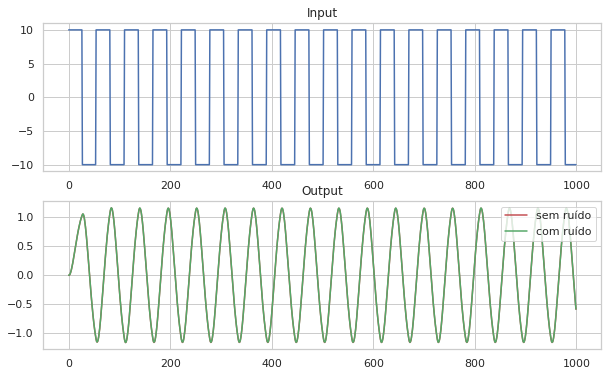

In [19]:
fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))

axes[0].set_title("Input")
axes[0].plot(t,UVAL,color='b')

axes[1].set_title("Output")
axes[1].plot(t,y,color='r',label='sem ruído')
axes[1].plot(t,YVAL,color='g',label='com ruído')
axes[1].legend(loc=1)

fig.savefig("funcoes-2.png",dpi=200, bbox_inches='tight')

In [20]:
Phi = np.concatenate((-YTRA[1:-1], -YTRA[0:-2], UTRA[1:-1], UTRA[0:-2]), axis=1)
PhiVAL = np.concatenate((-YVAL[1:-1], -YVAL[0:-2], UVAL[1:-1], UVAL[0:-2]), axis=1)
Y1 = YTRA[2:]
Y2 = YVAL[2:]

print(Phi.shape)

(998, 4)


In [21]:
# Need to pseudo inverse Phi matrix (pinv)
th_hat = np.dot(np.linalg.pinv(np.dot(Phi.conj().transpose(),Phi)), \
                np.dot(Phi.conj().transpose(),Y1))

In [22]:
yhat_TRA_OSA = np.dot(Phi,th_hat)
yhat_VAL_OSA = np.dot(PhiVAL,th_hat)

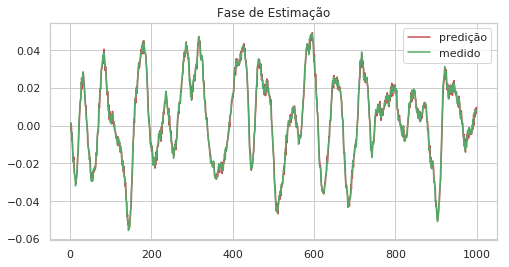

In [23]:
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Fase de Estimação")
axes.plot(t[2:],yhat_TRA_OSA,color='r',label='predição')
axes.plot(t[2:],Y1,color='g',label='medido')
axes.legend(loc=1)

fig.savefig("resultado_training.png",dpi=200, bbox_inches='tight')

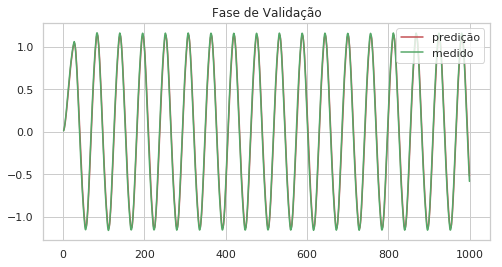

In [24]:
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Fase de Validação")
axes.plot(t[2:],yhat_VAL_OSA,color='r',label='predição')
axes.plot(t[2:],Y2,color='g',label='medido')
axes.legend(loc=1)

fig.savefig("resultado_validate.png",dpi=200, bbox_inches='tight')

In [25]:
def plot_xcorrel(e,u):
    N = len(u)

    conf_factor = 1.96/np.sqrt(N)
    lag_vec = np.arange(0, N)
    
    conf = np.array([np.ones(len(lag_vec))*conf_factor, \
                     -1*np.ones(len(lag_vec))*conf_factor])
    
    EE = np.correlate(e,e, "same")
    UE = np.correlate(u,e, "same")
    EEU = np.correlate(e[0:-1], e[1:]*u[1:], "same")
    
    U2 = np.power(u,2) # element-wise power
    
    U2E = np.correlate(U2 - np.mean(U2),e, "same")
    U2E2 = np.correlate(U2 - np.mean(U2), \
                        np.power(e,2), "same")
    
    fig,axes = plt.subplots(nrows=5, ncols=1, figsize=(10,6))

    axes[0].plot(lag_vec,EE,color='b')
    axes[0].plot(lag_vec,conf[0],color='r',linestyle='--')
    axes[0].plot(lag_vec,conf[1],color='r',linestyle='--')
    axes[0].set_ylabel(r'$\phi_{\xi\xi}(\tau)$')
    axes[0].set_ylim([-1,1])
    axes[0].set_xticklabels([])
    
    axes[1].plot(lag_vec,UE,color='b')
    axes[1].plot(lag_vec,conf[0],color='r',linestyle='--')
    axes[1].plot(lag_vec,conf[1],color='r',linestyle='--')
    axes[1].set_ylabel(r'$\phi_{u\xi}(\tau)$')
    axes[1].set_ylim([-1,1])
    axes[1].set_xticklabels([])

    axes[2].plot(lag_vec[:-1],EEU,color='b')
    axes[2].plot(lag_vec[:-1],conf[0][1:],color='r',linestyle='--')
    axes[2].plot(lag_vec[:-1],conf[1][1:],color='r',linestyle='--')
    axes[2].set_ylabel(r'$\phi_{\xi(\xi u)}(\tau)$')
    axes[2].set_ylim([-1,1])
    axes[2].set_xticklabels([])

    axes[3].plot(lag_vec,U2E,color='b')
    axes[3].plot(lag_vec,conf[0],color='r',linestyle='--')
    axes[3].plot(lag_vec,conf[1],color='r',linestyle='--')
    axes[3].set_ylabel(r'$\phi_{(u^2) \xi}(\tau)$')
    axes[3].set_ylim([-1,1])
    axes[3].set_xticklabels([])
    
    axes[4].plot(lag_vec,U2E2,color='b')
    axes[4].plot(lag_vec,conf[0],color='r',linestyle='--')
    axes[4].plot(lag_vec,conf[1],color='r',linestyle='--')
    axes[4].set_ylabel(r'$\phi_{(u^2) \xi^2}(\tau)$')
    axes[4].set_ylim([-1,1])
    
    fig.savefig("resultado-corr.png",dpi=500, bbox_inches='tight')

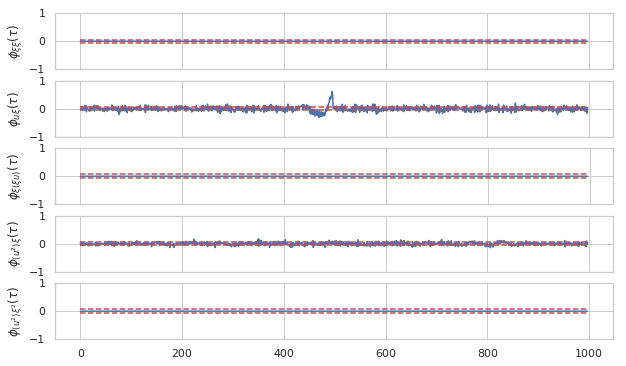

In [26]:
plot_xcorrel(Y1[:,0]-yhat_TRA_OSA[:,0], UTRA[2:,0])

In [27]:
# free run simulation
yhat_TRA_FR = np.zeros((N,1))
yhat_VAL_FR = np.zeros((N,1))
yhat_TRA_FR[0:2] = YTRA[0:2] # initialize with measurements
yhat_VAL_FR[0:2] = YVAL[0:2] # initialize with measurements

In [28]:
for k in range(2,N):
    yhat_TRA_FR[k] =    -th[0]*yhat_TRA_FR[k-1] - th[1]*yhat_TRA_FR[k-2] \
                        + th[2]*UTRA[k-1] + th[3]*UTRA[k-2]
    yhat_VAL_FR[k] =    -th[0]*yhat_VAL_FR[k-1] - th[1]*yhat_VAL_FR[k-2] \
                        + th[2]*UVAL[k-1] + th[3]*UVAL[k-2]

In [29]:
yhat_TRA_FR = yhat_TRA_FR[2:] # remove measurements
yhat_VAL_FR = yhat_VAL_FR[2:] # remove measurements

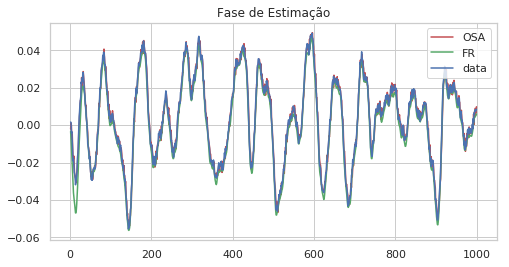

In [30]:
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Fase de Estimação")
axes.plot(t[2:],yhat_TRA_OSA,color='r',label='OSA')
axes.plot(t[2:],yhat_TRA_FR,color='g',label='FR')
axes.plot(t[2:],Y1,color='b',label='data')
axes.legend(loc=1)

fig.savefig("resultado_fr_training.png",dpi=200, bbox_inches='tight')

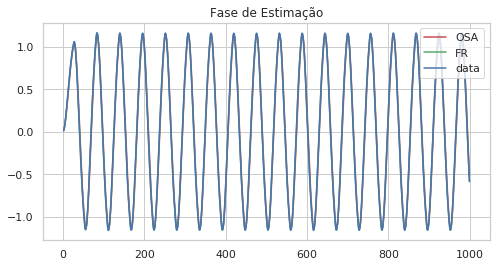

In [31]:
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Fase de Estimação")
axes.plot(t[2:],yhat_VAL_OSA,color='r',label='OSA')
axes.plot(t[2:],yhat_VAL_FR,color='g',label='FR')
axes.plot(t[2:],Y2,color='b',label='data')
axes.legend(loc=1)

fig.savefig("resultado_fr_validation.png",dpi=200, bbox_inches='tight')

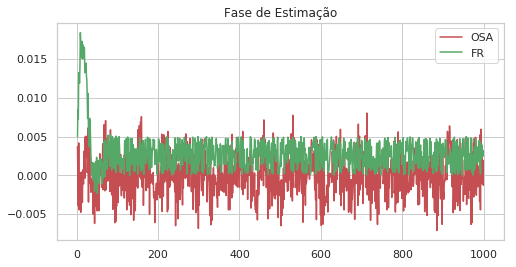

In [32]:
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Fase de Estimação")
axes.plot(t[2:],(Y1 - yhat_TRA_OSA),color='r',label='OSA')
axes.plot(t[2:],(Y1 - yhat_TRA_FR),color='g',label='FR')
axes.legend(loc=1)

fig.savefig("residuals_training.png",dpi=200, bbox_inches='tight')

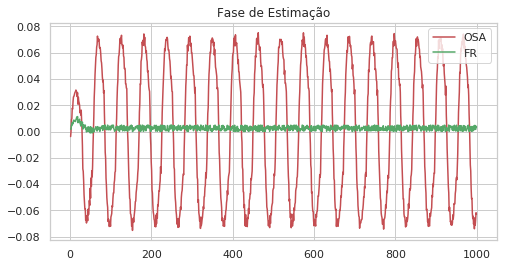

In [33]:
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Fase de Estimação")
axes.plot(t[2:],(Y2 - yhat_VAL_OSA),color='r',label='OSA')
axes.plot(t[2:],(Y2 - yhat_VAL_FR),color='g',label='FR')
axes.legend(loc=1)

fig.savefig("residuals_validation.png",dpi=200, bbox_inches='tight')

In [34]:
def mult_corr(real,est):
    # calculate R2 - multiple correlation coefficient
    SSE = np.sum(pow((real - est),2))
    avg_real = np.mean(real)
    sum2 = np.sum(pow((real - avg_real),2))
    return (1 - SSE / sum2)

In [35]:
# calculate metrics
R2_TRA_OSA = mult_corr(Y1,yhat_TRA_OSA);
R2_VAL_OSA = mult_corr(Y2,yhat_VAL_OSA);
R2_TRA_FR  = mult_corr(Y1,yhat_TRA_FR);
R2_VAL_FR  = mult_corr(Y2,yhat_VAL_FR);

print('R2 obtained (1 is perfect) \n')
print('R2_TRA_OSA \t R2_VAL_OSA \t R2_TRA_FR \t R2_VAL_FR\n')
print(  '%0.4f \t\t %0.4f \t %0.4f \t %0.4f\n' % \
        (R2_TRA_OSA,R2_VAL_OSA,R2_TRA_FR,R2_VAL_FR))

R2 obtained (1 is perfect) 

R2_TRA_OSA 	 R2_VAL_OSA 	 R2_TRA_FR 	 R2_VAL_FR

0.9846 		 0.9956 	 0.9723 	 1.0000



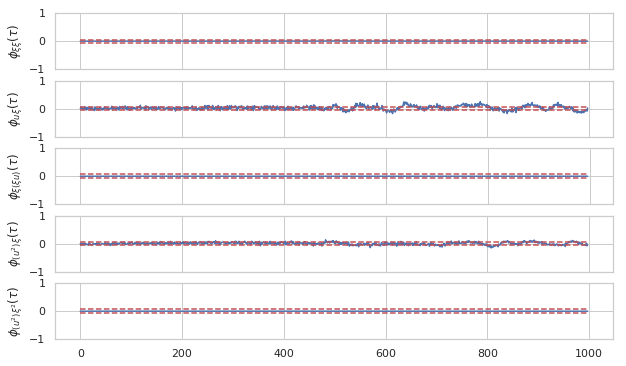

In [36]:
plot_xcorrel(Y1[:,0]-yhat_TRA_FR[:,0], UTRA[2:,0])